In [1]:
import sqlite3
import pandas as pd
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import normaltest
from scipy.stats import kruskal

In [2]:
conn = sqlite3.connect('../db/olist_ecommerce.db')

1 - Retention Analysis: Calculate the rate of repeat customers. A recurring customer is one who has placed more than one order in the period analysed. What insights can we extract from this data?

In [3]:
query = """
SELECT 
  c.customer_unique_id,
  o.order_id,
  o.order_purchase_timestamp,
  o.order_delivered_customer_date,
  o.order_approved_at,
  p.payment_value
FROM df_customers_dataset c
JOIN df_olist_orders_dataset o
  ON c.customer_id = o.customer_id
JOIN df_olist_order_payments_dataset p
  ON o.order_id = p.order_id
WHERE o.order_status = 'delivered'
"""

df_customer_retention = pd.read_sql_query(query, conn)

In [4]:

df_customer_retention['order_purchase_timestamp'] = pd.to_datetime(df_customer_retention['order_purchase_timestamp'])


df_customer_retention_sorted = df_customer_retention.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])


df_customer_retention_sorted['days_between'] = df_customer_retention_sorted.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days


inter_purchase_avg = df_customer_retention_sorted.groupby('customer_unique_id')['days_between'].mean().reset_index()
inter_purchase_avg.columns = ['customer_unique_id', 'avg_days_between_orders']

In [5]:
df_customer_retention['order_purchase_timestamp'] = pd.to_datetime(df_customer_retention['order_purchase_timestamp'])

orders_per_customer = df_customer_retention.groupby('customer_unique_id')['order_purchase_timestamp'].count().reset_index()
orders_per_customer.columns = ['customer_unique_id', 'order_count']


print(orders_per_customer['order_count'].value_counts())

order_count
1     87893
2      4581
3       524
4       156
5        70
6        49
7        30
8        12
9         9
11        7
12        5
13        4
10        4
15        3
14        3
19        2
16        1
22        1
26        1
33        1
23        1
Name: count, dtype: int64


In [6]:

returning_customers = orders_per_customer[orders_per_customer['order_count'] > 1]['customer_unique_id']


df_customer_retention_filtred = df_customer_retention[df_customer_retention['customer_unique_id'].isin(returning_customers)].copy()


df_customer_retention_filtred['order_purchase_timestamp'] = pd.to_datetime(df_customer_retention_filtred['order_purchase_timestamp'])

In [7]:
df_customer_retention_filtred.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12863 entries, 0 to 100749
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             12863 non-null  object        
 1   order_id                       12863 non-null  object        
 2   order_purchase_timestamp       12863 non-null  datetime64[ns]
 3   order_delivered_customer_date  12863 non-null  object        
 4   order_approved_at              12863 non-null  object        
 5   payment_value                  12863 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 703.4+ KB


In [8]:

data_base = df_customer_retention_filtred['order_purchase_timestamp'].max() + pd.Timedelta(days=1)


rfm = df_customer_retention_filtred.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (data_base - x.max()).days,  
    'order_id': 'nunique',                                            
    'payment_value': 'sum'                                            
}).reset_index()


rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary_value']

In [9]:

rfm['R'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])


rfm['F'] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])


rfm['M'] = pd.qcut(rfm['monetary_value'], 5, labels=[1, 2, 3, 4, 5])

In [10]:
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

print(rfm)

                    customer_unique_id  recency  frequency  monetary_value  R  \
0     000e309254ab1fc5ba99dd469d36bdb4       65          1           78.42  5   
1     0028a7d8db7b0247652509358ad8d755      259          1          354.87  3   
2     00324c9f4d710e7bac5c5ba679714430      434          1          109.78  1   
3     004288347e5e88a27ded2bb23747066c      227          2          354.37  3   
4     0058f300f57d7b93c477a131a59b36c3      160          1           96.02  4   
...                                ...      ...        ...             ... ..   
5459  ff9584b796ae561b0085ebc998880a64      159          1           50.05  4   
5460  ff9bc66daa6702543b16f3c4897e300b      541          1           97.99  1   
5461  ff9c04f464ea62ad7787a0218336b942      150          1           91.38  4   
5462  ffe254cc039740e17dd15a5305035928      514          2           80.12  1   
5463  ffeddf8aa7cdecf403e77b2e9a99e2ea      108          1          204.20  4   

      F  M RFM_Score  
0   

In [21]:

rfm['F'] = rfm['F'].astype(int)

# customer with frequency level >= 4
frequent_customers = rfm[rfm['F'] >= 4]['customer_unique_id']

# All the orders to the clientes with frequency level >= 4
df_freq = df_customer_retention[df_customer_retention['customer_unique_id'].isin(frequent_customers)].copy()

In [22]:
df_freq['order_purchase_timestamp'] = pd.to_datetime(df_freq['order_purchase_timestamp'])
df_freq['month'] = df_freq['order_purchase_timestamp'].dt.month

shopping_by_month = df_freq['month'].value_counts().sort_index()
print(shopping_by_month)

month
1     423
2     489
3     485
4     401
5     530
6     469
7     511
8     501
9     264
10    276
11    365
12    269
Name: count, dtype: int64


In [23]:

query = """
SELECT 
  c.customer_unique_id,
  c.customer_state
FROM df_customers_dataset c
"""
df_customers = pd.read_sql_query(query, conn)


df_freq_customers = df_freq.merge(df_customers, on='customer_unique_id', how='left')


customer_state_counts = df_freq_customers['customer_state'].value_counts()
print(customer_state_counts.head(10))

customer_state
SP    5180
RJ    1546
MG    1264
RS     631
PR     571
SC     370
BA     355
GO     265
ES     254
DF     206
Name: count, dtype: int64


In [24]:
query_category = """
SELECT 
  o.order_id,
  p.product_category_name
FROM df_order_items_com_datas o
JOIN df_olist_products_dataset p
  ON o.product_id = p.product_id
"""
df_categories = pd.read_sql_query(query_category, conn)


df_freq_categories = df_freq.merge(df_categories, on='order_id', how='left')


category_counts = df_freq_categories['product_category_name'].value_counts()
print(category_counts.head(10))

product_category_name
cama_mesa_banho                935
moveis_decoracao               660
esporte_lazer                  526
beleza_saude                   448
informatica_acessorios         445
utilidades_domesticas          360
relogios_presentes             251
ferramentas_jardim             241
fashion_bolsas_e_acessorios    221
brinquedos                     194
Name: count, dtype: int64


In [25]:
avg_ticket = df_freq.groupby('customer_unique_id')['payment_value'].mean().sort_values(ascending=False)
print(avg_ticket.describe())

count    2186.000000
mean      143.064774
std       152.928444
min         7.075455
25%        69.786250
50%       105.877500
75%       167.031250
max      3785.815000
Name: payment_value, dtype: float64


In [26]:

total_customers = df_customer_retention['customer_unique_id'].nunique()


recurring_customers = returning_customers.nunique()


recurrence_rate = (recurring_customers / total_customers) * 100

print(f"Rate of repeat customers: {recurrence_rate:.2f}%")

Rate of repeat customers: 5.85%


1 - Retention Analysis: Calculate the rate of repeat customers. A recurring customer is one who has placed more than one order in the period analysed. What insights can we draw from this data?

While the rate of repeat customers represents 5.85% of total customers, some insights can be drawn about this group.

When analysing the common factors between customers classified with purchase frequency levels 4 and 5, it can be seen that the months of May, July and August are when this group makes the most purchases. In contrast, the months at the end of the year have the lowest consumption figures. This phenomenon occurs because, during the end-of-year festivities, consumers tend to prioritise purchases of gifts for others, increasing the flow of new customers, even with the presence of seasonal promotions.

The states of São Paulo, Minas Gerais and Rio de Janeiro concentrate the largest number of customers of this profile, which can be attributed to the region's high population density and greater purchasing power. These factors indicate a strategic opportunity for investment in physical shops in these markets.

With regard to product categories, there is an interesting pattern of preference: bed, bath and table and furniture and decoration are the segments most sought after by these consumers, followed by sport and leisure and beauty and health. As these groups have similar profiles and close target audiences, it is recommended to implement combined promotions, associating bed, table and bath with furniture and decoration, and sport and leisure with beauty and health.

Finally, it is essential to consider price ranges between R$69 and R$167, which represent the average ticket for this group of customers, guaranteeing competitive offers in line with their consumption patterns.



2 - Delay prediction: Create a simple model to predict whether an order will be delivered late.

In [27]:
query_features = """
SELECT
  order_id,
  MAX(customer_state) AS customer_state,
  MAX(seller_state) AS seller_state,
  SUM(freight_value) AS total_freight_value,
  SUM(weight_kg) AS total_weight,
  SUM(volume_m3) AS total_volume,
  COUNT(product_id) AS qtt_item_order,
  MAX(distance_km) AS distance_km
FROM df_freight
GROUP BY order_id
"""
df_features = pd.read_sql_query(query_features, conn)

In [28]:
output_path_ready = 'df_features.csv'
df_features.to_csv(output_path_ready, index=False)

In [30]:
query_date = """
SELECT
    order_id,
    order_delivered_carrier_date AS carried_date,
    order_delivered_customer_date AS delivered_date,
    order_estimated_delivery_date AS estimated_date
FROM df_olist_orders_dataset
"""
df_date = pd.read_sql_query(query_date, conn)

In [31]:
df_predictive_model_delay = df_features.merge(df_date, on='order_id', how='left')

In [32]:
df_predictive_model_delay['delivered_date'] = pd.to_datetime(df_predictive_model_delay['delivered_date']).dt.date
df_predictive_model_delay['estimated_date'] = pd.to_datetime(df_predictive_model_delay['estimated_date']).dt.date

df_predictive_model_delay['estimated_month'] = pd.to_datetime(df_predictive_model_delay['estimated_date']).dt.month


In [33]:

df_predictive_model_delay['delivered_date'] = pd.to_datetime(df_predictive_model_delay['delivered_date'])
df_predictive_model_delay['estimated_date'] = pd.to_datetime(df_predictive_model_delay['estimated_date'])


df_predictive_model_delay['delay_days'] = (df_predictive_model_delay['delivered_date'] - df_predictive_model_delay['estimated_date']).dt.days


df_predictive_model_delay['is_not_late'] = (df_predictive_model_delay['delay_days'] <= 0).astype(int)

In [34]:
output_path_ready = 'df_predictive_model_delay.csv'
df_predictive_model_delay.to_csv(output_path_ready, index=False)

In [35]:
df_encoded = pd.get_dummies(df_predictive_model_delay, columns=['customer_state', 'seller_state', 'estimated_month'], drop_first=True)

In [36]:

X = df_encoded.drop(columns=['order_id', 'delivered_date', 'estimated_date', 'carried_date', 'is_not_late', 'delay_days'])
y = df_encoded['is_not_late']

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


# Logistic Regression
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

c:\Users\lpraz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred_log), precision_score(y_test, y_pred_rf)],
    'Recall': [recall_score(y_test, y_pred_log), recall_score(y_test, y_pred_rf)],
    'F1 Score': [f1_score(y_test, y_pred_log), f1_score(y_test, y_pred_rf)]
})

print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.932222   0.932368  0.999832  0.964922
1        Random Forest  0.928731   0.936421  0.990836  0.962860


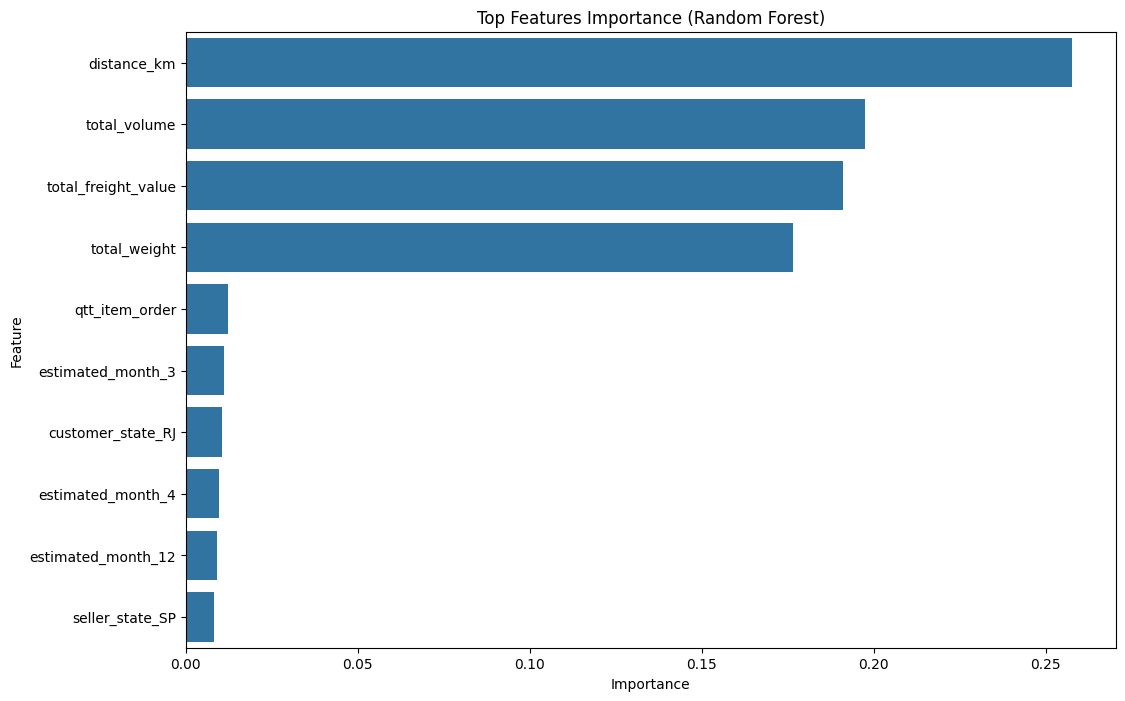

In [38]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})


feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


top_10_features = feature_importances.head(10)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top Features Importance (Random Forest)')
plt.show()

In [39]:
def predict_delay(distance_km, total_volume, total_freight_value, total_weight):
    import numpy as np

    
    input_data = np.array([[distance_km, total_volume, total_freight_value, total_weight]])

   
    selected_features = ['distance_km', 'total_volume', 'total_freight_value', 'total_weight']
    rf_model_selected = RandomForestClassifier(random_state=42)
    rf_model_selected.fit(X_train[selected_features], y_train)
    
   
    prediction = rf_model_selected.predict(input_data)

    if prediction[0] == 1:
        print("✅ Order delivered on time.")
    else:
        print("⚠️ The order will be delivered late.")


predict_delay(distance_km=9000, total_volume=5.0, total_freight_value=80.0, total_weight=50.0)

⚠️ The order will be delivered late.


c:\Users\lpraz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In this analysis, two classification models were used in Machine Learning-Random Forest and Logistic Regression-with the aim of estimating the probability of delay in the delivery of an order. In addition, the variables that have the greatest impact on predicting delivery status were identified. The results indicate that factors such as delivery distance, freight price, volume and weight of the item significantly influence the possibility of a delivery delay.

As such, these factors represent critical points that the company must address together with the logistics team in order to mitigate potential delays and optimise the distribution process.

3 - Customer segmentation: Use clustering techniques to segment customers into groups. Analyse the behaviour of each group and suggest specific marketing strategies for each one.



In [41]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary_value']])

In [42]:
inertia = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

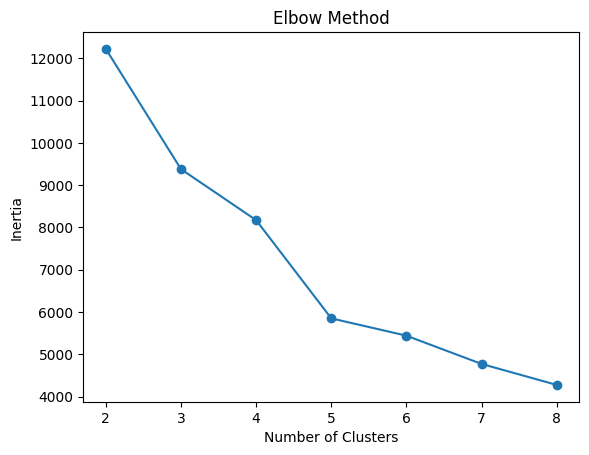

In [43]:
plt.plot(range(2, 9), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [44]:
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

In [45]:
rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(2)

recency frequency monetary_value      
           mean      mean           mean count
cluster                                       
0        417.05      1.00         140.04  1085
1        205.40      1.99        1410.70   172
2        149.57      1.00         136.77  1521
3        370.19      2.07         251.54  1064
4        122.61      2.12         270.14  1622

Taking advantage of the analysis of customer retention begun in question 1, it was possible to segment customers into five groups using the K-Means clustering model based on RFM criteria. In this way, we can better understand the different profiles of repeat customers and develop strategies to strengthen and improve existing relationships.

- Group 4 - Premium customers:
High frequency, recently purchased and spend more.
Strategy: Loyalty programme, exclusive coupons, anticipation of launches.

- Group 1 - Inconsistent big spenders:
High average spend, but average recency.
Strategy: Reactivation campaigns with VIP discounts and personalised calls.

- Group 3 - Good inactive customers:
Have bought a lot, but are absent.
Strategy: Re-engagement with return campaigns and feedback surveys.

- Cluster 2 and 0 - Low-value one-off buyers:
High recency, but have only bought once.
Strategy: Upsell, cross-sell and first repurchase campaigns.



4 - Satisfaction Analysis: Explore the relationship between customer ratings and different aspects such as product category, delivery time, order value, etc. Identify factors that have the greatest impact on customer satisfaction.

In [111]:
query_review = """
WITH customer_orders AS (
    SELECT 
        customer_unique_id,
        COUNT(DISTINCT order_id) AS total_orders
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    GROUP BY customer_unique_id
),

review_data AS (
    SELECT
        r.review_id,
        r.review_score,
        r.review_comment_title,
        r.review_comment_message,
        o.order_id,
        o.order_purchase_timestamp,
        o.order_delivered_customer_date,
        o.order_delivered_customer_date, 
        o.order_purchase_timestamp,
        c.customer_unique_id
    FROM df_olist_order_reviews_dataset r
    JOIN df_olist_orders_dataset o ON r.order_id = o.order_id
    JOIN df_customers_dataset c ON o.customer_id = c.customer_id
    LEFT JOIN df_customers_dataset co ON c.customer_unique_id = co.customer_unique_id
),

order_item_data AS (
    SELECT
        oi.order_id,
        oi.product_id,
        p.product_category_name,
        oi.seller_id,
        oi.price,
        oi.freight_value,
        (oi.price + oi.freight_value) AS total_item_revenue
    FROM df_order_items_com_datas oi
    JOIN df_olist_products_dataset p ON oi.product_id = p.product_id
)

SELECT
    rd.review_id,
    rd.review_score,
    rd.review_comment_title,
    rd.review_comment_message,
    rd.order_id,
    rd.order_purchase_timestamp,
    rd.order_delivered_customer_date,
    rd.customer_unique_id,
    oid.product_id,
    oid.product_category_name,
    oid.seller_id,
    oid.price,
    oid.freight_value,
    oid.total_item_revenue
FROM review_data rd
JOIN order_item_data oid ON rd.order_id = oid.order_id;
"""


df_customer_review = pd.read_sql_query(query_review, conn)





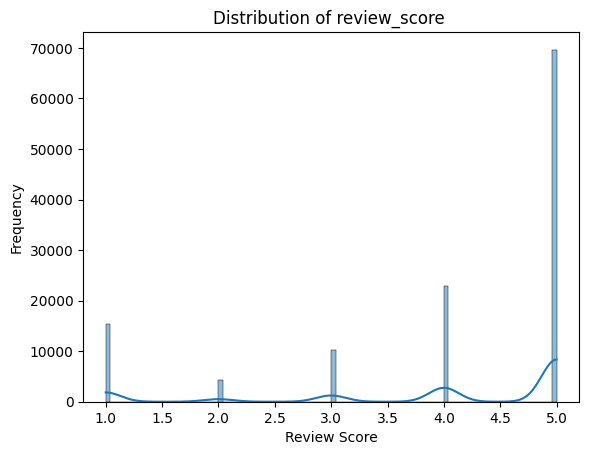

In [112]:
sns.histplot(df_customer_review['review_score'], kde=True)
plt.title("Distribution of review_score ")
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.show()

In [113]:

df_customer_review['order_purchase_timestamp'] = pd.to_datetime(df_customer_review['order_purchase_timestamp'])
df_customer_review['order_delivered_customer_date'] = pd.to_datetime(df_customer_review['order_delivered_customer_date'])


df_customer_review['delivery_time_days'] = (df_customer_review['order_delivered_customer_date'] - df_customer_review['order_purchase_timestamp']).dt.days


df_clean = df_customer_review[df_customer_review['delivery_time_days'] > 0]


In [114]:

category_metrics = df_customer_review.groupby('product_category_name').agg({
    'review_score': 'mean',
    'order_id': 'count',
    'total_item_revenue': 'sum'
}).rename(columns={
    'review_score': 'avg_review',
    'order_id': 'sales_volume',
    'total_item_revenue': 'revenue'
}).reset_index()


scaler = StandardScaler()
scaled = scaler.fit_transform(category_metrics[['avg_review', 'sales_volume', 'revenue']])


kmeans = KMeans(n_clusters=3, random_state=42)
category_metrics['cluster'] = kmeans.fit_predict(scaled)


cluster_mean = category_metrics.groupby('cluster')[['avg_review', 'sales_volume', 'revenue']].mean()


def label_cluster(row):
    if row['cluster'] == cluster_mean['revenue'].idxmax():
        return 'Best Seller'
    elif row['cluster'] == cluster_mean['avg_review'].idxmin():
        return 'Low Quality'
    else:
        return 'Not Profitable'

category_metrics['category_type'] = category_metrics.apply(label_cluster, axis=1)

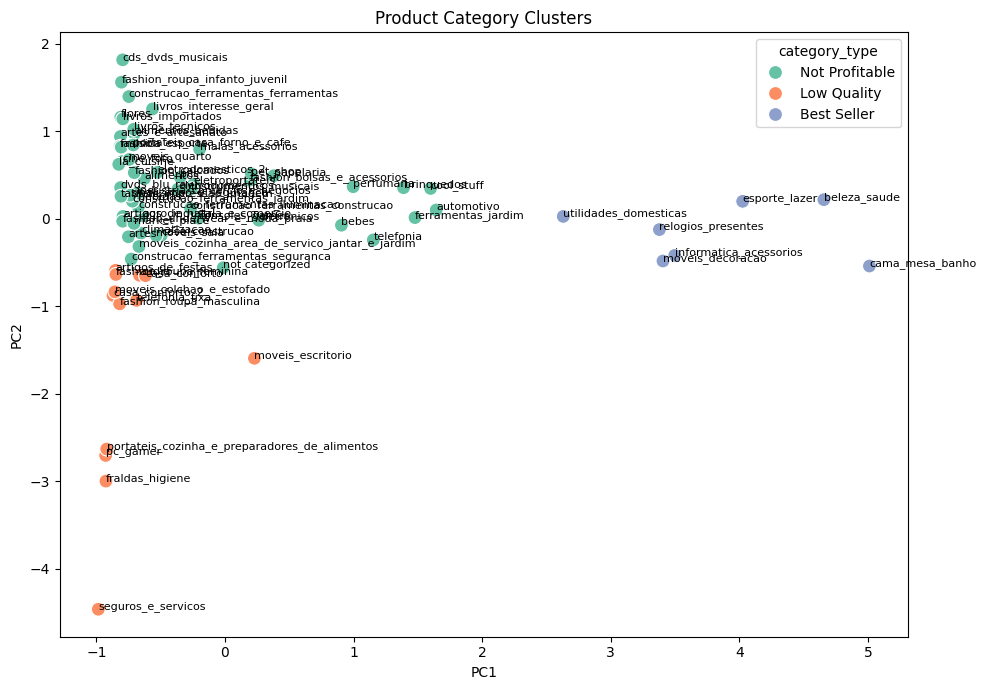

In [115]:

pca = PCA(n_components=2)
components = pca.fit_transform(scaled)
category_metrics['PC1'] = components[:, 0]
category_metrics['PC2'] = components[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=category_metrics,
    x='PC1',
    y='PC2',
    hue='category_type',
    palette='Set2',
    s=100
)
for i in range(len(category_metrics)):
    plt.text(
        category_metrics['PC1'][i],
        category_metrics['PC2'][i],
        category_metrics['product_category_name'][i],
        fontsize=8
    )
plt.title("Product Category Clusters")
plt.tight_layout()
plt.show()

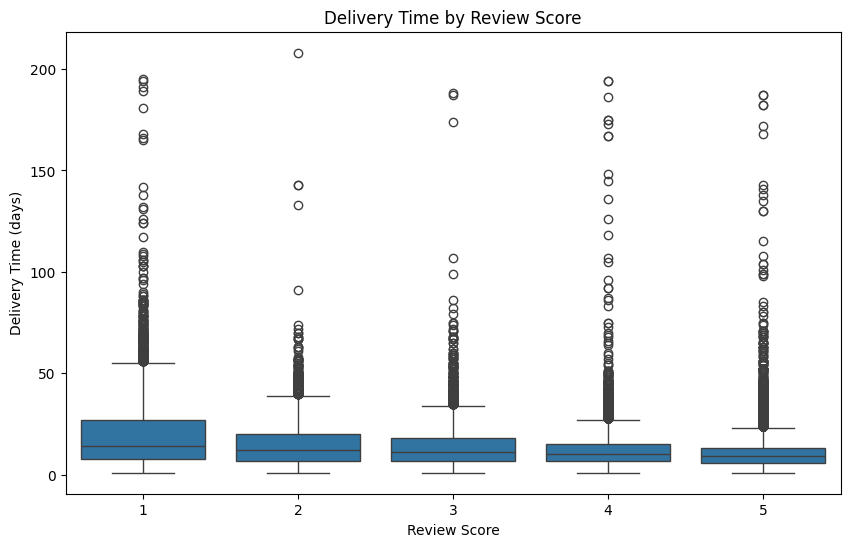

In [123]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_time_days', data=df_clean)
plt.title('Delivery Time by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (days)')
plt.show()

In [ ]:
# Hypothesis test: ‘Did customers who gave 1 star have longer delivery times than those who gave 5 stars?’

for score in range(1, 6):
    group = df_clean[df_clean['review_score'] == score]['delivery_time_days']
    stat, p = normaltest(group)
    print(f"Review Score = {score} | p = {p:.5f}")

#Is not normal distribution

Review Score = 1 | p = 0.00000
Review Score = 2 | p = 0.00000
Review Score = 3 | p = 0.00000
Review Score = 4 | p = 0.00000
Review Score = 5 | p = 0.00000


In [118]:
groups = [df_clean[df_clean['review_score'] == i]['delivery_time_days'] for i in range(1, 6)]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis: stat = {stat:.2f}, p = {p:.4f}")

Kruskal-Wallis: stat = 6294.62, p = 0.0000


p < 0.05, H₀ is rejected → delivery time significantly affects the grade.

In [119]:
seller_summary = df_customer_review.groupby('seller_id').agg({
    'review_score': 'mean',
    'order_id': 'count',
    'total_item_revenue': 'sum'
}).rename(columns={
    'review_score': 'avg_review_score',
    'order_id': 'sales_volume',
    'total_item_revenue': 'total_revenue'
}).reset_index()

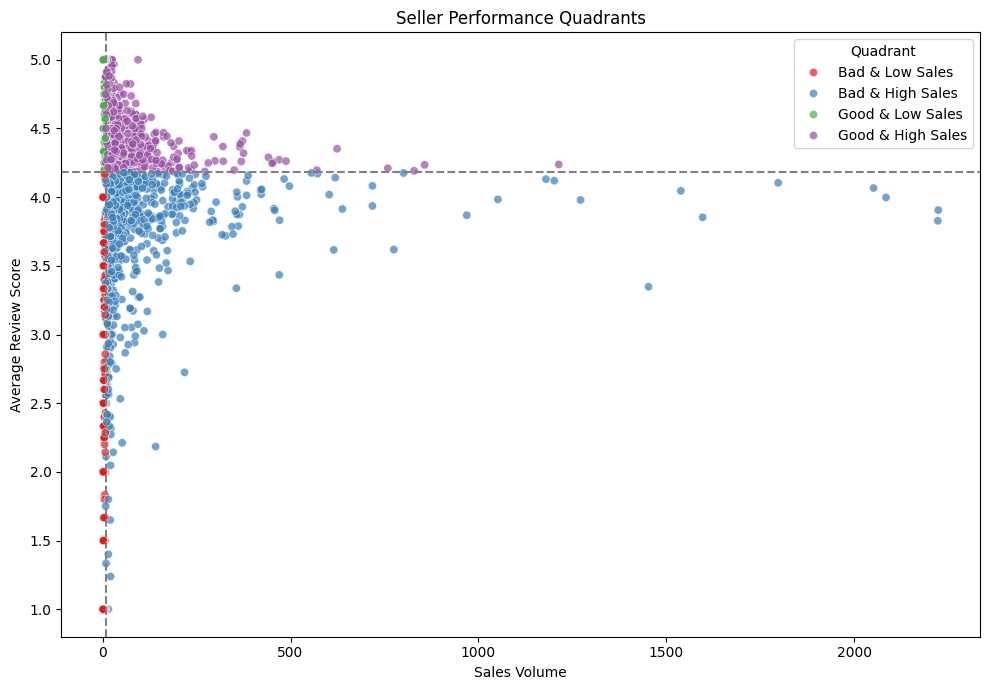

In [ ]:

volume_median = seller_summary['sales_volume'].median()
review_median = seller_summary['avg_review_score'].median()


def classify_seller(row):
    if row['avg_review_score'] >= review_median and row['sales_volume'] >= volume_median:
        return "Good & High Sales"
    elif row['avg_review_score'] >= review_median:
        return "Good & Low Sales"
    elif row['sales_volume'] >= volume_median:
        return "Bad & High Sales"
    else:
        return "Bad & Low Sales"

seller_summary['performance_quadrant'] = seller_summary.apply(classify_seller, axis=1)


plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=seller_summary,
    x='sales_volume',
    y='avg_review_score',
    hue='performance_quadrant',
    palette='Set1',
    alpha=0.7
)
plt.axvline(volume_median, color='gray', linestyle='--')
plt.axhline(review_median, color='gray', linestyle='--')
plt.title("Seller Performance Quadrants")
plt.xlabel("Sales Volume")
plt.ylabel("Average Review Score")
plt.legend(title='Quadrant')
plt.tight_layout()
plt.show()

In [121]:
group_counts = seller_summary['performance_quadrant'].value_counts().reset_index()
group_counts.columns = ['quadrant', 'count']
group_counts['proportion'] = group_counts['count'] / group_counts['count'].sum()
print(group_counts)

            quadrant  count  proportion
0   Bad & High Sales    845    0.273463
1   Good & Low Sales    795    0.257282
2  Good & High Sales    750    0.242718
3    Bad & Low Sales    700    0.226537


4 - Satisfaction Analysis: Explore the relationship between customer ratings and different aspects such as product category, delivery time, order value, etc. Identify factors that have the greatest impact on customer satisfaction.

Analysing Customer Reviews
Comparisons were made between customer ratings, product category, delivery time and salespeople. The relationship between reviews and commercial performance was investigated by segmenting them into three clusters:

Best Sellers: Categories with high ratings, high sales volume and turnover.

Unprofitable: Categories with high ratings but below average revenue.

Low Quality: Categories with lower average scores and lower commercial performance.

Impact of Delivery Time on Evaluation
To assess whether delivery time influences customer ratings, we applied the Kruskal-Wallis test, which is suitable for non-normally distributed data. As the p-value obtained was less than 0.05, we rejected the null hypothesis and concluded that there was a significant difference between the groups, indicating that delivery time affects customer ratings.

Salesperson Performance: Volume vs Rating
The analysis of salesperson performance considered the volume of orders fulfilled and the average rating received. We identified four distinct profiles:

Top Performers: High evaluation and high sales volume.

Underperformers: Low rating and low volume.

Efficient, but not in high demand.

Overloaded and poorly evaluated.

By mapping salespeople in the different quadrants, it is possible to prioritise actions, such as retention and rewards for the best, and training or replacement of underperformers.